In [114]:
from theano.sandbox import cuda
cuda.use('gpu2')

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

WARNING (theano.sandbox.cuda): Ignoring call to use(2), GPU number 0 is already in use.


In [180]:
HOMEPATH = "/home/ubuntu/fastai/"
DATAPATH = HOMEPATH + "data/mnist/"
print("HOMEPATH:", HOMEPATH)
print("DATAPATH:", DATAPATH)
import os

HOMEPATH: /home/ubuntu/fastai/
DATAPATH: /home/ubuntu/fastai/data/mnist/


In [3]:
os.chdir(HOMEPATH)
print ("os.getcwd:", os.getcwd())

%matplotlib inline
import utils; reload(utils)
from utils import *
from __future__ import division, print_function

('os.getcwd:', '/home/ubuntu/fastai')


Using Theano backend.


## Setup

In [116]:
def plot_history(histories):
    #histories : list of history objects. nb: history.history dictionary structure
    print ("len(histories):", len(histories))
    if len(histories)==1: 
        history = histories
    else:
        history = {}
        for i in histories[0].history.keys():
            history[i] = []
        #create empty history to copy into
        for hist in histories:
            for key in history.keys():
                history[key] += hist.history[key]
                #print (key, len(hist.history[key]), len(history[key]))

    # list all data in history
    print(history.keys(), len(history[history.keys()[0]]))
    # summarize history for accuracy
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validate'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validate'], loc='upper left')
    plt.show()

In [112]:
batch_size=64

In [113]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print ("X_train.shape:", X_train.shape, ", y_train.shape:", y_train.shape)
print ("X_test.shape:", X_test.shape, "y_test.shape:", y_test.shape)

X_train.shape: (60000, 28, 28) , y_train.shape: (60000,)
X_test.shape: (10000, 28, 28) y_test.shape: (10000,)


In [137]:
if len(X_test.shape)==3:
    print("expand shape")
    X_test = np.expand_dims(X_test,1)
    X_train = np.expand_dims(X_train,1)
else:
        print("expand shape already done, don't do again.")

print ("type(X_test):", type(X_test), X_test.shape)
print ("type(X_train):", type(X_train), X_train.shape)

expand shape
type(X_test): <type 'numpy.ndarray'> (10000, 1, 28, 28)
type(X_train): <type 'numpy.ndarray'> (60000, 1, 28, 28)


In [138]:
y_train[:5]

array([5, 0, 4, 1, 9], dtype=uint8)

In [139]:
print ("type(y_train):", type(y_train), y_train.shape, len(y_train.shape))
print ("type(y_test):", type(y_test), y_test.shape, len(y_test.shape))

type(y_train): <type 'numpy.ndarray'> (60000,) 1
type(y_test): <type 'numpy.ndarray'> (10000,) 1


In [140]:
if len(y_test.shape)==1:
    y_train = onehot(y_train)
else:
    print ("y_train already onehot'd, dont try again.")
y_test = onehot(y_test)
print ("type(y_train):", type(y_train), y_train.shape)
print ("type(y_test):", type(y_test), y_test.shape)

type(y_train): <type 'numpy.ndarray'> (60000, 10)
type(y_test): <type 'numpy.ndarray'> (10000, 10)


In [141]:
y_train[:5]

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]])

In [142]:
mean_px = X_train.mean().astype(np.float32)
std_px = X_train.std().astype(np.float32)

In [143]:
def norm_input(x): return (x-mean_px)/std_px

## Linear model

In [13]:
def get_lin_model():
    #get_lin_model(): creates model: Lambda w input (1,28,28), Flatten, Dense w 10 categories.
    model = Sequential([
        Lambda(norm_input, input_shape=(1,28,28)),
        Flatten(),
        Dense(10, activation='softmax')
        ])
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [14]:
lm = get_lin_model()

/usr/local/lib/python2.7/dist-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 1, 28, 28)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [15]:
lm.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 1, 28, 28)     0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 784)           0           lambda_1[0][0]                   
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 10)            7850        flatten_1[0][0]                  
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
____________________________________________________________________________________________________


In [16]:
gen = image.ImageDataGenerator()
#recall: (X_train, y_train), (X_test, y_test) = mnist.load_data()
batches = gen.flow(X_train, y_train, batch_size=64)
test_batches = gen.flow(X_test, y_test, batch_size=64)

In [17]:
print (type(gen))
print (type(batches))
print (type(test_batches))

<class 'keras.preprocessing.image.ImageDataGenerator'>
<class 'keras.preprocessing.image.NumpyArrayIterator'>
<class 'keras.preprocessing.image.NumpyArrayIterator'>


In [18]:
#using this to show attributes of ImageDataGenerator & NumpyArrayIterator 
#since documentation is poor and code provided has errors which needed fixing.

import inspect
def showAttribs(someObject):
    print(type(someObject))
    for i in inspect.getmembers(someObject):
        # Ignores anything starting with underscore 
        # (that is, private and protected attributes)
        if not i[0].startswith('_'):
            # Ignores methods
            if not inspect.ismethod(i[1]):
                print(i)

In [19]:
showAttribs(gen)

<class 'keras.preprocessing.image.ImageDataGenerator'>
('channel_axis', 1)
('channel_shift_range', 0.0)
('col_axis', 3)
('cval', 0.0)
('dim_ordering', 'th')
('featurewise_center', False)
('featurewise_std_normalization', False)
('fill_mode', 'nearest')
('height_shift_range', 0.0)
('horizontal_flip', False)
('mean', None)
('preprocessing_function', None)
('principal_components', None)
('rescale', None)
('rotation_range', 0.0)
('row_axis', 2)
('samplewise_center', False)
('samplewise_std_normalization', False)
('shear_range', 0.0)
('std', None)
('vertical_flip', False)
('width_shift_range', 0.0)
('zca_whitening', False)
('zoom_range', [1.0, 1.0])


In [20]:
showAttribs(batches)

<class 'keras.preprocessing.image.NumpyArrayIterator'>
('batch_index', 0)
('batch_size', 64)
('dim_ordering', 'th')
('image_data_generator', <keras.preprocessing.image.ImageDataGenerator object at 0x7fb62cb18e10>)
('index_generator', <generator object _flow_index at 0x7fb62d1bc3c0>)
('lock', <thread.lock object at 0x7fb637b70e50>)
('n', 60000)
('save_format', 'jpeg')
('save_prefix', '')
('save_to_dir', None)
('shuffle', True)
('total_batches_seen', 0)
('x', array([[[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ..., 
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]]],


       [[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         ..., 
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]

In [21]:
print ("test_batches.n:", test_batches.n)
print ("batches.n:", batches.n)

test_batches.n: 10000
batches.n: 60000


In [81]:
#recall: lm = get_lin_model(): creates model: Lambda w input (1,28,28), Flatten, Dense w 10 categories.
history1 = lm.fit_generator(batches, batches.n, nb_epoch=1, 
                    validation_data=test_batches, nb_val_samples=test_batches.n)

Epoch 1/1
60000/60000 [==============================] - 12s - loss: 0.2517 - acc: 0.9308 - val_loss: 0.2738 - val_acc: 0.9271


In [23]:
lm.optimizer.lr=0.1

In [34]:
history2 = lm.fit_generator(batches, batches.n, nb_epoch=1, 
                    validation_data=test_batches, nb_val_samples=test_batches.n)

Epoch 1/1
60000/60000 [==============================] - 12s - loss: 0.2666 - acc: 0.9254 - val_loss: 0.2867 - val_acc: 0.9209


In [25]:
lm.optimizer.lr=0.01

In [48]:
history3 = lm.fit_generator(batches, batches.n, nb_epoch=4, 
                    validation_data=test_batches, nb_val_samples=test_batches.n)

Epoch 1/4
60000/60000 [==============================] - 12s - loss: 0.2569 - acc: 0.9292 - val_loss: 0.2818 - val_acc: 0.9243
Epoch 2/4
60000/60000 [==============================] - 12s - loss: 0.2542 - acc: 0.9296 - val_loss: 0.2840 - val_acc: 0.9235
Epoch 3/4
60000/60000 [==============================] - 12s - loss: 0.2536 - acc: 0.9296 - val_loss: 0.2853 - val_acc: 0.9238
Epoch 4/4
60000/60000 [==============================] - 12s - loss: 0.2522 - acc: 0.9304 - val_loss: 0.2963 - val_acc: 0.9186


In [49]:
a=[1,2,3,4]
print (a)
print (a[1:])


[1, 2, 3, 4]
[2, 3, 4]


In [82]:
history = []
for h in [history1, history2, history3]:
    for key in h.history.keys():
        print (key, len(h.history[key]))


acc 1
loss 1
val_acc 1
val_loss 1
acc 1
loss 1
val_acc 1
val_loss 1
acc 4
loss 4
val_acc 4
val_loss 4


In [100]:
def combineHistory(histories):
    print ("len(histories):", len(histories))
    if len(histories)==1: 
        return histories
    else:
        combinedHistory = {}
        for i in histories[0].history.keys():
            combinedHistory[i] = []
        #create empty history to copy into
        for hist in histories:
            for key in combinedHistory.keys():
                combinedHistory[key] += hist.history[key]
                print (key, len(hist.history[key]))
    return combinedHistory

In [101]:
history = []
history = combineHistory([history1, history2, history3])

len(histories): 3
acc 1
loss 1
val_acc 1
val_loss 1
acc 1
loss 1
val_acc 1
val_loss 1
acc 4
loss 4
val_acc 4
val_loss 4


In [102]:
print (type(history))
for key in history.keys():
    print (key, type(history[key]), len(history[key]), history[key])
    

<type 'dict'>
acc <type 'list'> 6 [0.9307833333333333, 0.92544999999999999, 0.92923333333333336, 0.92958333333333332, 0.92961666666666665, 0.93036666666666668]
loss <type 'list'> 6 [0.25167250640392302, 0.26657652456760406, 0.25687337983449299, 0.25423061842918399, 0.25363582245508831, 0.25217201921145121]
val_acc <type 'list'> 6 [0.92710000000000004, 0.92090000000000005, 0.92430000000000001, 0.92349999999999999, 0.92379999999999995, 0.91859999999999997]
val_loss <type 'list'> 6 [0.27375929135084154, 0.28673139104843137, 0.28175568881034851, 0.28395132236182691, 0.28529580399990084, 0.29631049423217776]


In [103]:
print(history.keys())
print(history[history.keys()[0]])

['acc', 'loss', 'val_acc', 'val_loss']
[0.9307833333333333, 0.92544999999999999, 0.92923333333333336, 0.92958333333333332, 0.92961666666666665, 0.93036666666666668]


len(histories): 3
['acc', 'loss', 'val_acc', 'val_loss'] 6


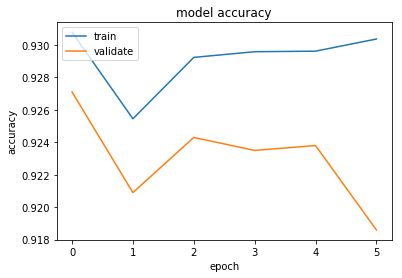

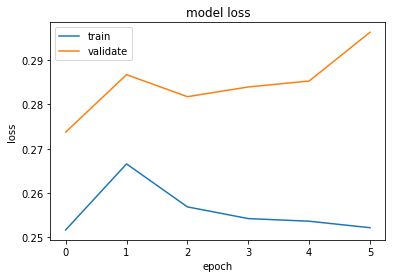

In [117]:
plot_history([history1, history2, history3])

## Single dense layer

In [118]:
def get_fc_model():
    #get_fc_model creates model: Lambda w input_shape=(1,28,28), Flatten, Dense(512), Dense (10 categories)
    model = Sequential([
        Lambda(norm_input, input_shape=(1,28,28)),
        Flatten(),
        Dense(512, activation='softmax'),
        Dense(10, activation='softmax')
        ])
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [119]:
fc = get_fc_model()

/usr/local/lib/python2.7/dist-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_2 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 1, 28, 28)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [120]:
fc.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 1, 28, 28)     0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
flatten_2 (Flatten)              (None, 784)           0           lambda_2[0][0]                   
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 512)           401920      flatten_2[0][0]                  
____________________________________________________________________________________________________
dense_3 (Dense)                  (None, 10)            5130        dense_2[0][0]                    
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
___________________

In [121]:
history1 = fc.fit_generator(batches, batches.n, nb_epoch=1, 
                    validation_data=test_batches, nb_val_samples=test_batches.n)

Epoch 1/1
60000/60000 [==============================] - 13s - loss: 1.5990 - acc: 0.7744 - val_loss: 1.1140 - val_acc: 0.8170


In [122]:
fc.optimizer.lr=0.1

In [123]:
history2 = fc.fit_generator(batches, batches.n, nb_epoch=4, 
                    validation_data=test_batches, nb_val_samples=test_batches.n)

Epoch 1/4
60000/60000 [==============================] - 12s - loss: 0.8559 - acc: 0.8279 - val_loss: 0.6614 - val_acc: 0.8384
Epoch 2/4
60000/60000 [==============================] - 13s - loss: 0.5935 - acc: 0.8364 - val_loss: 0.5361 - val_acc: 0.8354
Epoch 3/4
60000/60000 [==============================] - 13s - loss: 0.4949 - acc: 0.8413 - val_loss: 0.4636 - val_acc: 0.8443
Epoch 4/4
60000/60000 [==============================] - 13s - loss: 0.4537 - acc: 0.8450 - val_loss: 0.4399 - val_acc: 0.8431


In [124]:
fc.optimizer.lr=0.01

In [125]:
history3 = fc.fit_generator(batches, batches.n, nb_epoch=4, 
                    validation_data=test_batches, nb_val_samples=test_batches.n)

Epoch 1/4
60000/60000 [==============================] - 13s - loss: 0.4156 - acc: 0.8538 - val_loss: 0.4230 - val_acc: 0.8539
Epoch 2/4
60000/60000 [==============================] - 12s - loss: 0.3738 - acc: 0.8973 - val_loss: 0.3403 - val_acc: 0.9246
Epoch 3/4
60000/60000 [==============================] - 13s - loss: 0.2861 - acc: 0.9356 - val_loss: 0.2846 - val_acc: 0.9349
Epoch 4/4
60000/60000 [==============================] - 13s - loss: 0.2557 - acc: 0.9404 - val_loss: 0.2699 - val_acc: 0.9354


In [126]:
fc.optimizer.lr=0.001

In [127]:
history4 = fc.fit_generator(batches, batches.n, nb_epoch=4, 
                    validation_data=test_batches, nb_val_samples=test_batches.n)

Epoch 1/4
60000/60000 [==============================] - 13s - loss: 0.2446 - acc: 0.9414 - val_loss: 0.2837 - val_acc: 0.9305
Epoch 2/4
60000/60000 [==============================] - 13s - loss: 0.2311 - acc: 0.9432 - val_loss: 0.2662 - val_acc: 0.9339
Epoch 3/4
60000/60000 [==============================] - 12s - loss: 0.2248 - acc: 0.9439 - val_loss: 0.2672 - val_acc: 0.9356
Epoch 4/4
60000/60000 [==============================] - 13s - loss: 0.2148 - acc: 0.9465 - val_loss: 0.2640 - val_acc: 0.9364


len(histories): 4
['acc', 'loss', 'val_acc', 'val_loss'] 13


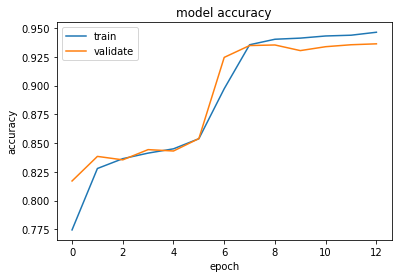

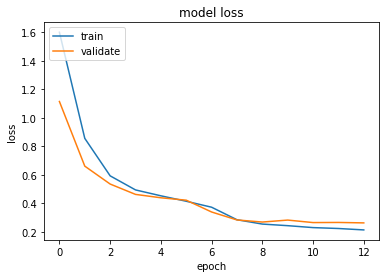

In [128]:
plot_history([history1, history2, history3, history4])

## Basic 'VGG-style' CNN

In [129]:
def get_model():
    #get_model() creates model w Lambda input_shape=(1,28,28), Convolution2D, Convolution2D, MaxPooling2D, 
    # Convolution2D, Convolution2D, MaxPooling2D, Flatten, Dense, Dense w output 10 categories.
    model = Sequential([
        Lambda(norm_input, input_shape=(1,28,28)),
        Convolution2D(32,3,3, activation='relu'),
        Convolution2D(32,3,3, activation='relu'),
        MaxPooling2D(),
        Convolution2D(64,3,3, activation='relu'),
        Convolution2D(64,3,3, activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(10, activation='softmax')
        ])
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [130]:
model = get_model()

/usr/local/lib/python2.7/dist-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_3 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 1, 28, 28)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [ ]:
model.summary()

In [ ]:
history1 = model.fit_generator(batches, batches.n, nb_epoch=1, 
                    validation_data=test_batches, nb_val_samples=test_batches.n)

In [ ]:
model.optimizer.lr=0.1

In [ ]:
history2 = model.fit_generator(batches, batches.n, nb_epoch=1, 
                    validation_data=test_batches, nb_val_samples=test_batches.n)

In [ ]:
model.optimizer.lr=0.01

In [ ]:
history3 = model.fit_generator(batches, batches.n, nb_epoch=8, 
                    validation_data=test_batches, nb_val_samples=test_batches.n)

len(histories): 3
['acc', 'loss', 'val_acc', 'val_loss'] 9


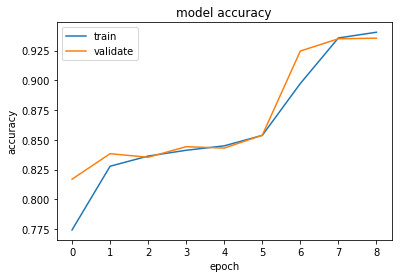

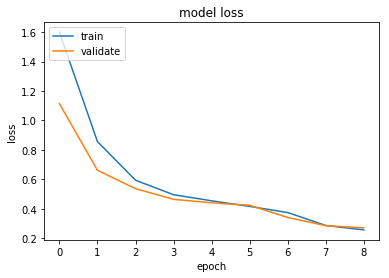

In [131]:
plot_history([history1, history2, history3])

## Data augmentation

In [132]:
model = get_model()

/usr/local/lib/python2.7/dist-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_4 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 1, 28, 28)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [133]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_4 (Lambda)                (None, 1, 28, 28)     0           lambda_input_4[0][0]             
____________________________________________________________________________________________________
convolution2d_5 (Convolution2D)  (None, 32, 26, 26)    320         lambda_4[0][0]                   
____________________________________________________________________________________________________
convolution2d_6 (Convolution2D)  (None, 32, 24, 24)    9248        convolution2d_5[0][0]            
____________________________________________________________________________________________________
maxpooling2d_3 (MaxPooling2D)    (None, 32, 12, 12)    0           convolution2d_6[0][0]            
___________________________________________________________________________________________

In [136]:
print ("X_train:", type(X_train), X_train.shape, "y_train:", type(y_train), y_train.shape)
print ("X_test:", type(X_test), X_test.shape, "y_test:", type(y_test), y_test.shape)


X_train: <type 'numpy.ndarray'> (60000, 28, 28) y_train: <type 'numpy.ndarray'> (60000,)
X_test: <type 'numpy.ndarray'> (10000, 28, 28) y_test: <type 'numpy.ndarray'> (10000,)


In [ ]:
#Batchnormalisation : uses batches and test_batches created from image.ImageDataGenerator.flow(blah...)
gen = image.ImageDataGenerator(rotation_range=8, 
                               width_shift_range=0.08, 
                               shear_range=0.3,
                               height_shift_range=0.08, 
                               zoom_range=0.08)

batches = gen.flow(X_train, y_train, batch_size=64)
test_batches = gen.flow(X_test, y_test, batch_size=64)
print ("batches.n:", batches.n)
print ("test_batches.n:", test_batches.n)

In [145]:
history1 = model.fit_generator(batches, batches.n, nb_epoch=1, 
                    validation_data=test_batches, nb_val_samples=test_batches.n)

Epoch 1/1
60000/60000 [==============================] - 25s - loss: 0.1988 - acc: 0.9361 - val_loss: 0.0655 - val_acc: 0.9807


In [146]:
model.optimizer.lr=0.1

In [147]:
history2 = model.fit_generator(batches, batches.n, nb_epoch=4, 
                    validation_data=test_batches, nb_val_samples=test_batches.n)

Epoch 1/4
60000/60000 [==============================] - 25s - loss: 0.0704 - acc: 0.9786 - val_loss: 0.0462 - val_acc: 0.9849
Epoch 2/4
60000/60000 [==============================] - 24s - loss: 0.0539 - acc: 0.9826 - val_loss: 0.0435 - val_acc: 0.9874
Epoch 3/4
60000/60000 [==============================] - 26s - loss: 0.0485 - acc: 0.9844 - val_loss: 0.0385 - val_acc: 0.9865
Epoch 4/4
60000/60000 [==============================] - 25s - loss: 0.0409 - acc: 0.9873 - val_loss: 0.0422 - val_acc: 0.9870


In [148]:
model.optimizer.lr=0.01

In [149]:
history3 = model.fit_generator(batches, batches.n, nb_epoch=8, 
                    validation_data=test_batches, nb_val_samples=test_batches.n)

Epoch 1/8
60000/60000 [==============================] - 24s - loss: 0.0391 - acc: 0.9881 - val_loss: 0.0428 - val_acc: 0.9875
Epoch 2/8
60000/60000 [==============================] - 24s - loss: 0.0365 - acc: 0.9886 - val_loss: 0.0353 - val_acc: 0.9889
Epoch 3/8
60000/60000 [==============================] - 24s - loss: 0.0336 - acc: 0.9898 - val_loss: 0.0299 - val_acc: 0.9897
Epoch 4/8
60000/60000 [==============================] - 24s - loss: 0.0327 - acc: 0.9901 - val_loss: 0.0332 - val_acc: 0.9888
Epoch 5/8
60000/60000 [==============================] - 25s - loss: 0.0309 - acc: 0.9905 - val_loss: 0.0256 - val_acc: 0.9908
Epoch 6/8
60000/60000 [==============================] - 24s - loss: 0.0269 - acc: 0.9915 - val_loss: 0.0329 - val_acc: 0.9892
Epoch 7/8
60000/60000 [==============================] - 25s - loss: 0.0300 - acc: 0.9903 - val_loss: 0.0268 - val_acc: 0.9919
Epoch 8/8
60000/60000 [==============================] - 25s - loss: 0.0272 - acc: 0.9917 - val_loss: 0.0280 - 

In [150]:
model.optimizer.lr=0.001

In [151]:
history4 = model.fit_generator(batches, batches.n, nb_epoch=14, 
                    validation_data=test_batches, nb_val_samples=test_batches.n)

Epoch 1/14
60000/60000 [==============================] - 25s - loss: 0.0258 - acc: 0.9917 - val_loss: 0.0316 - val_acc: 0.9907
Epoch 2/14
60000/60000 [==============================] - 25s - loss: 0.0247 - acc: 0.9925 - val_loss: 0.0303 - val_acc: 0.9905
Epoch 3/14
60000/60000 [==============================] - 25s - loss: 0.0254 - acc: 0.9922 - val_loss: 0.0297 - val_acc: 0.9910
Epoch 4/14
60000/60000 [==============================] - 24s - loss: 0.0248 - acc: 0.9928 - val_loss: 0.0396 - val_acc: 0.9895
Epoch 5/14
60000/60000 [==============================] - 24s - loss: 0.0218 - acc: 0.9932 - val_loss: 0.0255 - val_acc: 0.9931
Epoch 6/14
60000/60000 [==============================] - 24s - loss: 0.0219 - acc: 0.9929 - val_loss: 0.0334 - val_acc: 0.9895
Epoch 7/14
60000/60000 [==============================] - 24s - loss: 0.0232 - acc: 0.9931 - val_loss: 0.0313 - val_acc: 0.9906
Epoch 8/14
60000/60000 [==============================] - 25s - loss: 0.0210 - acc: 0.9934 - val_loss: 0

In [152]:
model.optimizer.lr=0.0001

In [153]:
history5 = model.fit_generator(batches, batches.n, nb_epoch=10, 
                    validation_data=test_batches, nb_val_samples=test_batches.n)

Epoch 1/10
60000/60000 [==============================] - 24s - loss: 0.0188 - acc: 0.9944 - val_loss: 0.0333 - val_acc: 0.9893
Epoch 2/10
60000/60000 [==============================] - 24s - loss: 0.0177 - acc: 0.9943 - val_loss: 0.0264 - val_acc: 0.9917
Epoch 3/10
60000/60000 [==============================] - 24s - loss: 0.0187 - acc: 0.9941 - val_loss: 0.0374 - val_acc: 0.9889
Epoch 4/10
60000/60000 [==============================] - 25s - loss: 0.0184 - acc: 0.9941 - val_loss: 0.0360 - val_acc: 0.9898
Epoch 5/10
60000/60000 [==============================] - 24s - loss: 0.0179 - acc: 0.9944 - val_loss: 0.0289 - val_acc: 0.9921
Epoch 6/10
60000/60000 [==============================] - 24s - loss: 0.0171 - acc: 0.9950 - val_loss: 0.0347 - val_acc: 0.9911
Epoch 7/10
60000/60000 [==============================] - 24s - loss: 0.0189 - acc: 0.9940 - val_loss: 0.0278 - val_acc: 0.9921
Epoch 8/10
60000/60000 [==============================] - 25s - loss: 0.0176 - acc: 0.9949 - val_loss: 0

len(histories): 5
['acc', 'loss', 'val_acc', 'val_loss'] 37


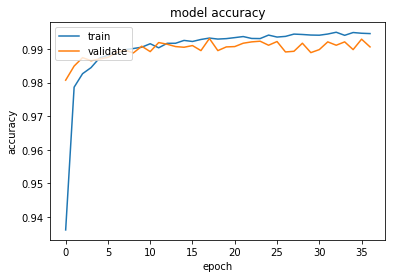

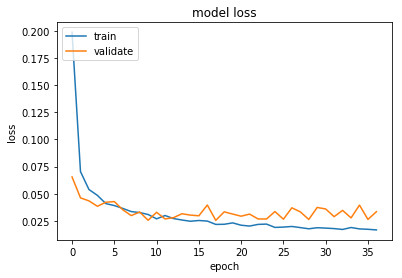

In [154]:
plot_history([history1, history2, history3, history4, history5])

## Batchnorm + data augmentation

In [155]:
#Batchnormalisation : uses batches and test_batches created from image.ImageDataGenerator.flow(blah...)

def get_model_bn():
    model = Sequential([
        Lambda(norm_input, input_shape=(1,28,28)),
        Convolution2D(32,3,3, activation='relu'),
        BatchNormalization(axis=1),
        Convolution2D(32,3,3, activation='relu'),
        MaxPooling2D(),
        BatchNormalization(axis=1),
        Convolution2D(64,3,3, activation='relu'),
        BatchNormalization(axis=1),
        Convolution2D(64,3,3, activation='relu'),
        MaxPooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dense(10, activation='softmax')
        ])
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [156]:
model = get_model_bn()

/usr/local/lib/python2.7/dist-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_5 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 1, 28, 28)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [157]:
history1 = model.fit_generator(batches, batches.n, nb_epoch=1, 
                    validation_data=test_batches, nb_val_samples=test_batches.n)

Epoch 1/1
60000/60000 [==============================] - 38s - loss: 0.1547 - acc: 0.9529 - val_loss: 0.0642 - val_acc: 0.9800


In [158]:
model.optimizer.lr=0.1

In [159]:
history2 = model.fit_generator(batches, batches.n, nb_epoch=4, 
                    validation_data=test_batches, nb_val_samples=test_batches.n)

Epoch 1/4
60000/60000 [==============================] - 38s - loss: 0.0725 - acc: 0.9776 - val_loss: 0.0564 - val_acc: 0.9826
Epoch 2/4
60000/60000 [==============================] - 37s - loss: 0.0585 - acc: 0.9818 - val_loss: 0.0495 - val_acc: 0.9829
Epoch 3/4
60000/60000 [==============================] - 38s - loss: 0.0518 - acc: 0.9835 - val_loss: 0.0437 - val_acc: 0.9870
Epoch 4/4
60000/60000 [==============================] - 37s - loss: 0.0490 - acc: 0.9842 - val_loss: 0.0401 - val_acc: 0.9852


In [160]:
model.optimizer.lr=0.01

In [161]:
history3 = model.fit_generator(batches, batches.n, nb_epoch=12, 
                    validation_data=test_batches, nb_val_samples=test_batches.n)

Epoch 1/12
60000/60000 [==============================] - 38s - loss: 0.0427 - acc: 0.9860 - val_loss: 0.0331 - val_acc: 0.9900
Epoch 2/12
60000/60000 [==============================] - 38s - loss: 0.0420 - acc: 0.9872 - val_loss: 0.0384 - val_acc: 0.9887
Epoch 3/12
60000/60000 [==============================] - 38s - loss: 0.0387 - acc: 0.9881 - val_loss: 0.0437 - val_acc: 0.9864
Epoch 4/12
60000/60000 [==============================] - 37s - loss: 0.0371 - acc: 0.9885 - val_loss: 0.0320 - val_acc: 0.9894
Epoch 5/12
60000/60000 [==============================] - 38s - loss: 0.0353 - acc: 0.9890 - val_loss: 0.0330 - val_acc: 0.9890
Epoch 6/12
60000/60000 [==============================] - 38s - loss: 0.0330 - acc: 0.9901 - val_loss: 0.0263 - val_acc: 0.9912
Epoch 7/12
60000/60000 [==============================] - 38s - loss: 0.0329 - acc: 0.9897 - val_loss: 0.0256 - val_acc: 0.9922
Epoch 8/12
60000/60000 [==============================] - 38s - loss: 0.0291 - acc: 0.9909 - val_loss: 0

In [162]:
model.optimizer.lr=0.001

In [163]:
history4 = model.fit_generator(batches, batches.n, nb_epoch=12, 
                    validation_data=test_batches, nb_val_samples=test_batches.n)

Epoch 1/12
60000/60000 [==============================] - 38s - loss: 0.0221 - acc: 0.9929 - val_loss: 0.0312 - val_acc: 0.9908
Epoch 2/12
60000/60000 [==============================] - 38s - loss: 0.0226 - acc: 0.9935 - val_loss: 0.0257 - val_acc: 0.9913
Epoch 3/12
60000/60000 [==============================] - 37s - loss: 0.0254 - acc: 0.9920 - val_loss: 0.0262 - val_acc: 0.9925
Epoch 4/12
60000/60000 [==============================] - 38s - loss: 0.0226 - acc: 0.9928 - val_loss: 0.0264 - val_acc: 0.9915
Epoch 5/12
60000/60000 [==============================] - 38s - loss: 0.0210 - acc: 0.9934 - val_loss: 0.0257 - val_acc: 0.9910
Epoch 6/12
60000/60000 [==============================] - 39s - loss: 0.0231 - acc: 0.9929 - val_loss: 0.0183 - val_acc: 0.9939
Epoch 7/12
60000/60000 [==============================] - 38s - loss: 0.0228 - acc: 0.9927 - val_loss: 0.0257 - val_acc: 0.9920
Epoch 8/12
60000/60000 [==============================] - 38s - loss: 0.0195 - acc: 0.9936 - val_loss: 0

len(histories): 4
['acc', 'loss', 'val_acc', 'val_loss'] 29


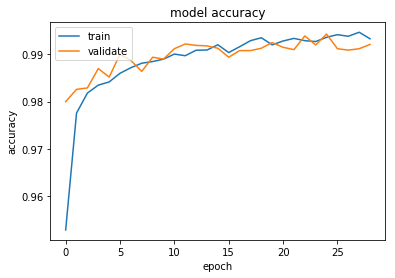

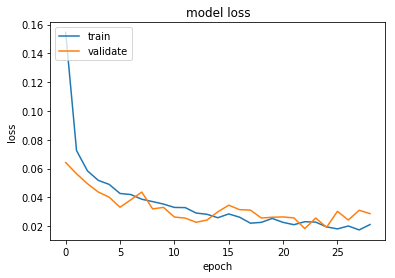

In [164]:
plot_history([history1, history2, history3, history4])

## Batchnorm + dropout + data augmentation

In [165]:
#Batchnormalisation : uses batches and test_batches created from image.ImageDataGenerator.flow(blah...)

def get_model_bn_do():
    model = Sequential([
        Lambda(norm_input, input_shape=(1,28,28)),
        Convolution2D(32,3,3, activation='relu'),
        BatchNormalization(axis=1),
        Convolution2D(32,3,3, activation='relu'),
        MaxPooling2D(),
        BatchNormalization(axis=1),
        Convolution2D(64,3,3, activation='relu'),
        BatchNormalization(axis=1),
        Convolution2D(64,3,3, activation='relu'),
        MaxPooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(10, activation='softmax')
        ])
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [166]:
model = get_model_bn_do()

/usr/local/lib/python2.7/dist-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_6 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 1, 28, 28)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [167]:
history1 = model.fit_generator(batches, batches.n, nb_epoch=1, 
                    validation_data=test_batches, nb_val_samples=test_batches.n)

Epoch 1/1
60000/60000 [==============================] - 39s - loss: 0.2164 - acc: 0.9355 - val_loss: 0.0738 - val_acc: 0.9763


In [168]:
model.optimizer.lr=0.1

In [169]:
history2 = model.fit_generator(batches, batches.n, nb_epoch=4, 
                    validation_data=test_batches, nb_val_samples=test_batches.n)

Epoch 1/4
60000/60000 [==============================] - 39s - loss: 0.0942 - acc: 0.9713 - val_loss: 0.0563 - val_acc: 0.9834
Epoch 2/4
60000/60000 [==============================] - 39s - loss: 0.0760 - acc: 0.9765 - val_loss: 0.0379 - val_acc: 0.9882
Epoch 3/4
60000/60000 [==============================] - 39s - loss: 0.0664 - acc: 0.9793 - val_loss: 0.0526 - val_acc: 0.9828
Epoch 4/4
60000/60000 [==============================] - 38s - loss: 0.0609 - acc: 0.9813 - val_loss: 0.0337 - val_acc: 0.9890


In [170]:
model.optimizer.lr=0.01

In [171]:
history3 = model.fit_generator(batches, batches.n, nb_epoch=12, 
                    validation_data=test_batches, nb_val_samples=test_batches.n)

Epoch 1/12
60000/60000 [==============================] - 40s - loss: 0.0556 - acc: 0.9837 - val_loss: 0.0355 - val_acc: 0.9874
Epoch 2/12
60000/60000 [==============================] - 38s - loss: 0.0537 - acc: 0.9831 - val_loss: 0.0452 - val_acc: 0.9855
Epoch 3/12
60000/60000 [==============================] - 38s - loss: 0.0505 - acc: 0.9842 - val_loss: 0.0322 - val_acc: 0.9898
Epoch 4/12
60000/60000 [==============================] - 39s - loss: 0.0475 - acc: 0.9850 - val_loss: 0.0289 - val_acc: 0.9898
Epoch 5/12
60000/60000 [==============================] - 38s - loss: 0.0469 - acc: 0.9856 - val_loss: 0.0388 - val_acc: 0.9862
Epoch 6/12
60000/60000 [==============================] - 39s - loss: 0.0451 - acc: 0.9857 - val_loss: 0.0263 - val_acc: 0.9913
Epoch 7/12
60000/60000 [==============================] - 38s - loss: 0.0415 - acc: 0.9875 - val_loss: 0.0239 - val_acc: 0.9915
Epoch 8/12
60000/60000 [==============================] - 38s - loss: 0.0417 - acc: 0.9876 - val_loss: 0

In [174]:
model.optimizer.lr=0.001

In [175]:
history4 = model.fit_generator(batches, batches.n, nb_epoch=1, 
                    validation_data=test_batches, nb_val_samples=test_batches.n)

Epoch 1/1
60000/60000 [==============================] - 39s - loss: 0.0347 - acc: 0.9890 - val_loss: 0.0246 - val_acc: 0.9927


len(histories): 4
['acc', 'loss', 'val_acc', 'val_loss'] 18


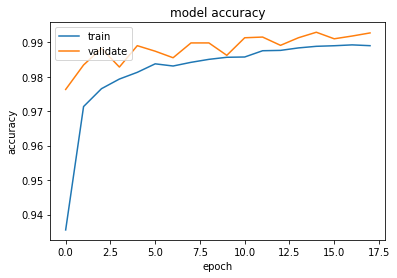

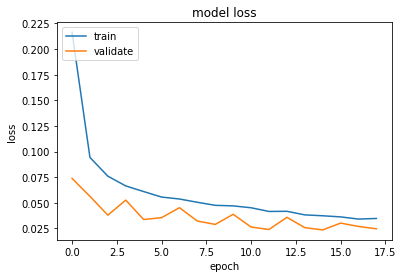

In [176]:
plot_history([history1, history2, history3, history4])

## Ensembling

In [177]:
def fit_model():
    model = get_model_bn_do()
    model.summary()
    print ("model.optimizer.lr:", model.optimizer.lr)
    history1 = model.fit_generator(batches, batches.n, nb_epoch=1, verbose=0,
                        validation_data=test_batches, nb_val_samples=test_batches.n)
    print("model.fit_generator(..) completed with model.optimizer.lr:", model.optimizer.lr)
    model.optimizer.lr=0.1
    history2 = model.fit_generator(batches, batches.n, nb_epoch=4, verbose=0,
                        validation_data=test_batches, nb_val_samples=test_batches.n)
    print("model.fit_generator(..) completed with model.optimizer.lr:", model.optimizer.lr)
    model.optimizer.lr=0.01
    history3 = model.fit_generator(batches, batches.n, nb_epoch=12, verbose=0,
                        validation_data=test_batches, nb_val_samples=test_batches.n)
    print("model.fit_generator(..) completed with model.optimizer.lr:", model.optimizer.lr)
    model.optimizer.lr=0.001
    history4 = model.fit_generator(batches, batches.n, nb_epoch=18, verbose=0,
                        validation_data=test_batches, nb_val_samples=test_batches.n)
    print("model.fit_generator(..) completed with model.optimizer.lr:", model.optimizer.lr)
    plot_history([history1, history2, history3, history4])
    return model

/usr/local/lib/python2.7/dist-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_7 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 1, 28, 28)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_7 (Lambda)                (None, 1, 28, 28)     0           lambda_input_7[0][0]             
____________________________________________________________________________________________________
convolution2d_17 (Convolution2D) (None, 32, 26, 26)    320         lambda_7[0][0]                   
____________________________________________________________________________________________________
batchnormalization_11 (BatchNorm (None, 32, 26, 26)    128         convolution2d_17[0][0]           
____________________________________________________________________________________________________
convolution2d_18 (Convolution2D) (None, 32, 24, 24)    9248        batchnormalization_11[0][0]      
___________________________________________________________________________________________

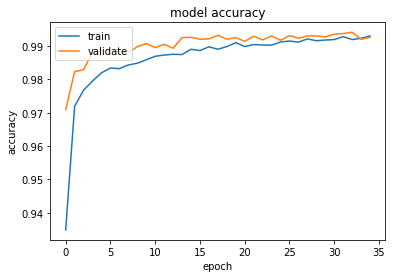

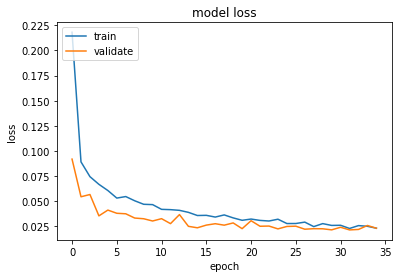

/usr/local/lib/python2.7/dist-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_8 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 1, 28, 28)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_8 (Lambda)                (None, 1, 28, 28)     0           lambda_input_8[0][0]             
____________________________________________________________________________________________________
convolution2d_21 (Convolution2D) (None, 32, 26, 26)    320         lambda_8[0][0]                   
____________________________________________________________________________________________________
batchnormalization_16 (BatchNorm (None, 32, 26, 26)    128         convolution2d_21[0][0]           
____________________________________________________________________________________________________
convolution2d_22 (Convolution2D) (None, 32, 24, 24)    9248        batchnormalization_16[0][0]      
___________________________________________________________________________________________

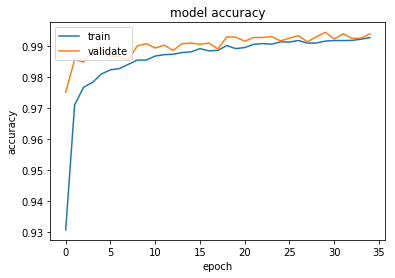

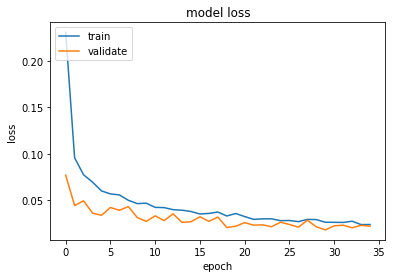

/usr/local/lib/python2.7/dist-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_9 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 1, 28, 28)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_9 (Lambda)                (None, 1, 28, 28)     0           lambda_input_9[0][0]             
____________________________________________________________________________________________________
convolution2d_25 (Convolution2D) (None, 32, 26, 26)    320         lambda_9[0][0]                   
____________________________________________________________________________________________________
batchnormalization_21 (BatchNorm (None, 32, 26, 26)    128         convolution2d_25[0][0]           
____________________________________________________________________________________________________
convolution2d_26 (Convolution2D) (None, 32, 24, 24)    9248        batchnormalization_21[0][0]      
___________________________________________________________________________________________

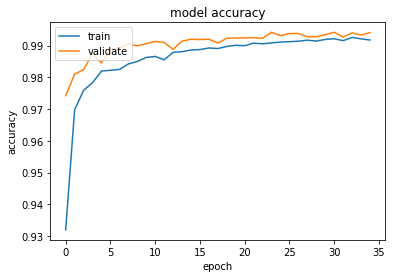

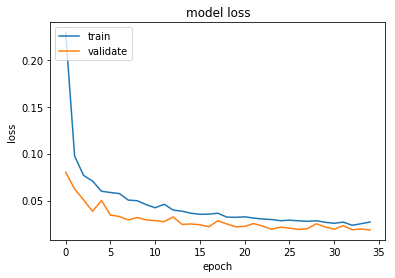

/usr/local/lib/python2.7/dist-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_10 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 1, 28, 28)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_10 (Lambda)               (None, 1, 28, 28)     0           lambda_input_10[0][0]            
____________________________________________________________________________________________________
convolution2d_29 (Convolution2D) (None, 32, 26, 26)    320         lambda_10[0][0]                  
____________________________________________________________________________________________________
batchnormalization_26 (BatchNorm (None, 32, 26, 26)    128         convolution2d_29[0][0]           
____________________________________________________________________________________________________
convolution2d_30 (Convolution2D) (None, 32, 24, 24)    9248        batchnormalization_26[0][0]      
___________________________________________________________________________________________

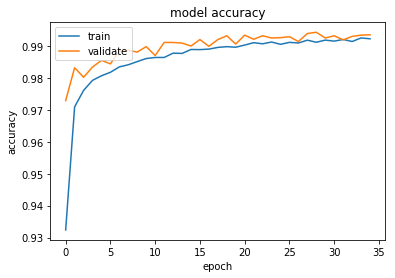

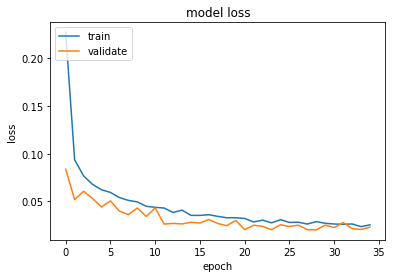

/usr/local/lib/python2.7/dist-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_11 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 1, 28, 28)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_11 (Lambda)               (None, 1, 28, 28)     0           lambda_input_11[0][0]            
____________________________________________________________________________________________________
convolution2d_33 (Convolution2D) (None, 32, 26, 26)    320         lambda_11[0][0]                  
____________________________________________________________________________________________________
batchnormalization_31 (BatchNorm (None, 32, 26, 26)    128         convolution2d_33[0][0]           
____________________________________________________________________________________________________
convolution2d_34 (Convolution2D) (None, 32, 24, 24)    9248        batchnormalization_31[0][0]      
___________________________________________________________________________________________

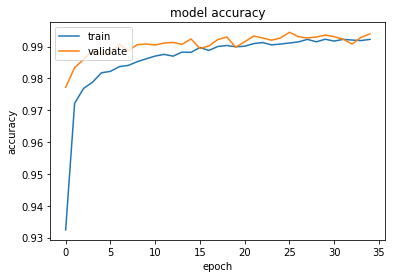

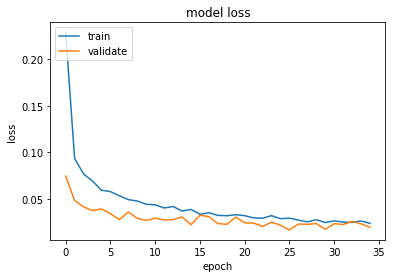

/usr/local/lib/python2.7/dist-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_12 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 1, 28, 28)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_12 (Lambda)               (None, 1, 28, 28)     0           lambda_input_12[0][0]            
____________________________________________________________________________________________________
convolution2d_37 (Convolution2D) (None, 32, 26, 26)    320         lambda_12[0][0]                  
____________________________________________________________________________________________________
batchnormalization_36 (BatchNorm (None, 32, 26, 26)    128         convolution2d_37[0][0]           
____________________________________________________________________________________________________
convolution2d_38 (Convolution2D) (None, 32, 24, 24)    9248        batchnormalization_36[0][0]      
___________________________________________________________________________________________

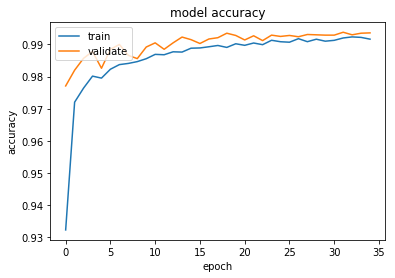

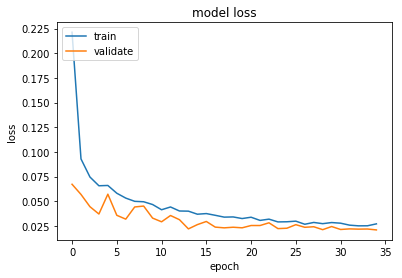

In [178]:
models = [fit_model() for i in range(6)]

In [181]:
model_path = DATAPATH + 'models/'

In [184]:
print ("models:", type(models), len(models))

models: <type 'list'> 6


In [182]:
for i,m in enumerate(models):
    m.save_weights(model_path+'cnn-mnist23-'+str(i)+'.pkl')#nb: why .pkl instead of .h5? .pkl usually for pickle.

In [185]:
evals = np.array([m.evaluate(X_test, y_test, batch_size=256) for m in models])

 9472/10000 [===========================>..] - ETA: 0s

In [186]:
print ("evals:", evals.shape)

evals: (6, 2)


In [187]:
evals_mean = evals.mean(axis=0)

In [188]:
print ("evals_mean:", evals_mean.shape)

evals_mean: (2,)


In [189]:
print (evals_mean)

[ 0.0119  0.9964]


In [190]:
all_preds = np.stack([m.predict(X_test, batch_size=256) for m in models])

In [191]:
all_preds.shape

(6, 10000, 10)

In [192]:
avg_preds = all_preds.mean(axis=0)

In [193]:
avg_preds.shape

(10000, 10)

In [194]:
keras.metrics.categorical_accuracy(y_test, avg_preds).eval()

array(0.9972000122070312, dtype=float32)